2025-01-07 10:35:18.203655: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 10:35:18.392400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')
         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


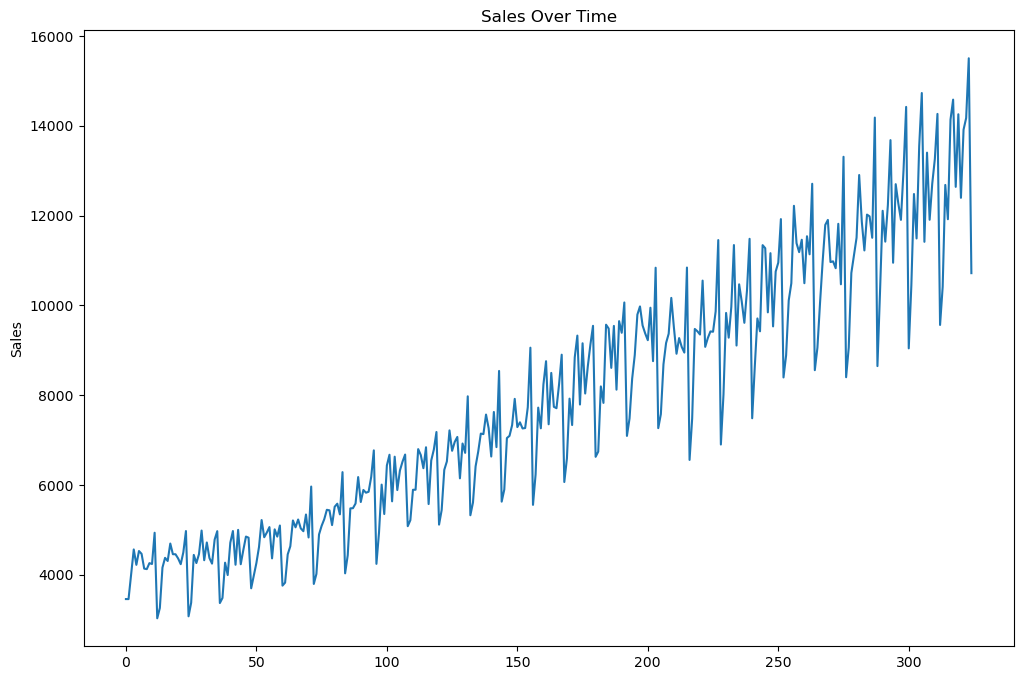

Epoch 1/100


/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1267 - mean_absolute_error: 0.2685 - val_loss: 0.0134 - val_mean_absolute_error: 0.0928
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0914 - val_loss: 0.0104 - val_mean_absolute_error: 0.0772
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - mean_absolute_error: 0.0800 - val_loss: 0.0074 - val_mean_absolute_error: 0.0635
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mean_absolute_error: 0.0928 - val_loss: 0.0069 - val_mean_absolute_error: 0.0615
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - mean_absolute_error: 0.0747 - val_loss: 0.0090 - val_mean_absolute_error: 0.0716
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mean_absolute_error: 0.0709 - val_loss: 0.0068 - val_mean_absolute_error: 0.0616
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - mean_absolute_error: 0.0801 - val_loss: 0.0084 - v

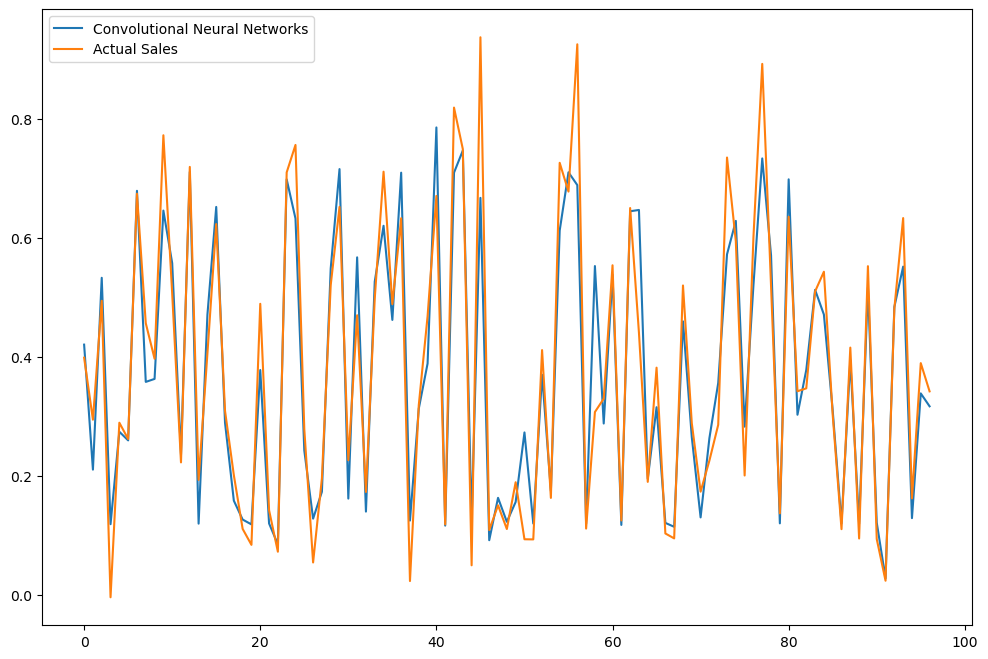

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout

# Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Update with the correct file path

# Debug: Print column names to identify the sales column
print("Original columns:", df.columns)

# Adjust column names based on actual dataset
df.columns = ['DATE', 'Sales']  # Adjust if necessary

# Debug: Verify the updated DataFrame
print(df.head())

# Plot the sales data
df['DATE'] = pd.to_datetime(df['DATE'])

# Plot the data
plt.figure(figsize=(12, 8))  # Create a new figure
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Create lag features for past months
df['Sale_LastMonth'] = df['Sales'].shift(+1)
df['Sale_2Monthsback'] = df['Sales'].shift(+2)
df['Sale_3Monthback'] = df['Sales'].shift(+3)

# Drop rows with missing values (due to shifting)
df = df.dropna()

# Prepare input (X) and output (y)
x = df.iloc[:, 2:].values  # Lag features
y = df.iloc[:, 1:2].values  # Current sales

# Split the data into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

# Reshape input for CNN (samples, time steps, features)
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

# Build the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(xtrain.shape[1], 1)),
    Dropout(0.2),  # Dropout for regularization
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(xtrain, ytrain, epochs=100, batch_size=5, validation_data=(xtest, ytest))

# Save the loss and validation loss to a CSV file
loss_data = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})
loss_data.to_csv('training_loss.csv', index=False)

# Evaluate the model
loss, mae = model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict and plot
predict = model.predict(xtest)
plt.figure(figsize=(12, 8))
plt.plot(predict, label='Convolutional Neural Networks')
plt.plot(ytest, label='Actual Sales')
plt.legend(loc='upper left')
plt.show()


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the Keras model
def create_model(activation='relu'):
    model = Sequential()
    model.add(Dense(64, input_dim=10, activation=activation))  # Adjust input_dim to match your data
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation='linear'))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Wrap the model in KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Define the parameter grid
param_grid = {
    'model__activation': ['relu', 'tanh'],  # Prefix 'model__' is required for model parameters
    'batch_size': [16, 32],
    'epochs': [10, 20],
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(xtrain, ytrain)

# Summarize the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


2025-01-07 11:11:01.669522: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 11:11:01.689221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 11:11:01.705779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 11:11:01.710285: I tensorflow/core/util/port.cc:153

ValueError: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 3, 1), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 3, 1), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 3, 1), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 3, 1), dtype=float32)
  • training=True
  • mask=None


Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')
         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


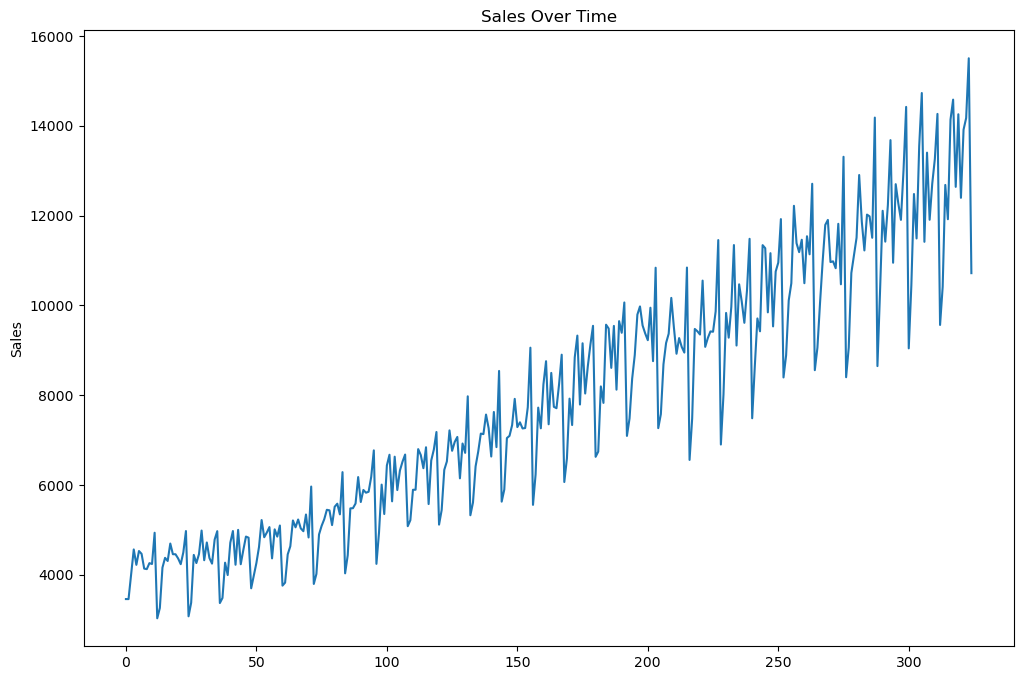

Reloading Tuner from my_dir/lstm_sales_tuning/tuner0.json


KeyError: 'num_layers does not exist.'

In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

# Step 1: Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Ensure the file path is correct

# Step 2: Explore and preprocess the data
print("Original columns:", df.columns)  # Display column names
df.columns = ['DATE', 'Sales']  # Rename columns if needed
print(df.head())  # Display the first few rows

# Convert the DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Plot the sales data
plt.figure(figsize=(12, 8))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Step 3: Create lagged features
df['Sale_LastMonth'] = df['Sales'].shift(1)
df['Sale_2Monthsback'] = df['Sales'].shift(2)
df['Sale_3Monthback'] = df['Sales'].shift(3)

# Drop rows with missing values due to shifting
df = df.dropna()

# Step 4: Prepare the data
x = df.iloc[:, 2:].values  # Use lagged features as input
y = df.iloc[:, 1:2].values  # Use current sales as target

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

# Reshape the data for LSTM input
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

# Step 5: Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    # Add LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):  # Number of LSTM layers
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=16),
            activation='relu',
            return_sequences=(i < hp.get('num_layers') - 1),  # Return sequences for all but the last layer
            input_shape=(xtrain.shape[1], 1) if i == 0 else None
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layers
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# Step 6: Hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_sales_tuning'
)

# Run the tuner
tuner.search(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), batch_size=5)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of LSTM layers is {best_hps.get('num_layers')},
with the following units per layer: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}.
The dropout rates are {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))]}.
The dense layer has {best_hps.get('dense_units')} units.
The optimizer is {best_hps.get('optimizer')}.
""")

# Step 7: Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(xtrain, ytrain, epochs=60, batch_size=5, validation_data=(xtest, ytest))

# Step 8: Evaluate the best model
loss, mae = best_model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Step 9: Predict and visualize results
predictions = best_model.predict(xtest)
predictions_rescaled = scaler_y.inverse_transform(predictions)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend()
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()


Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')
         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


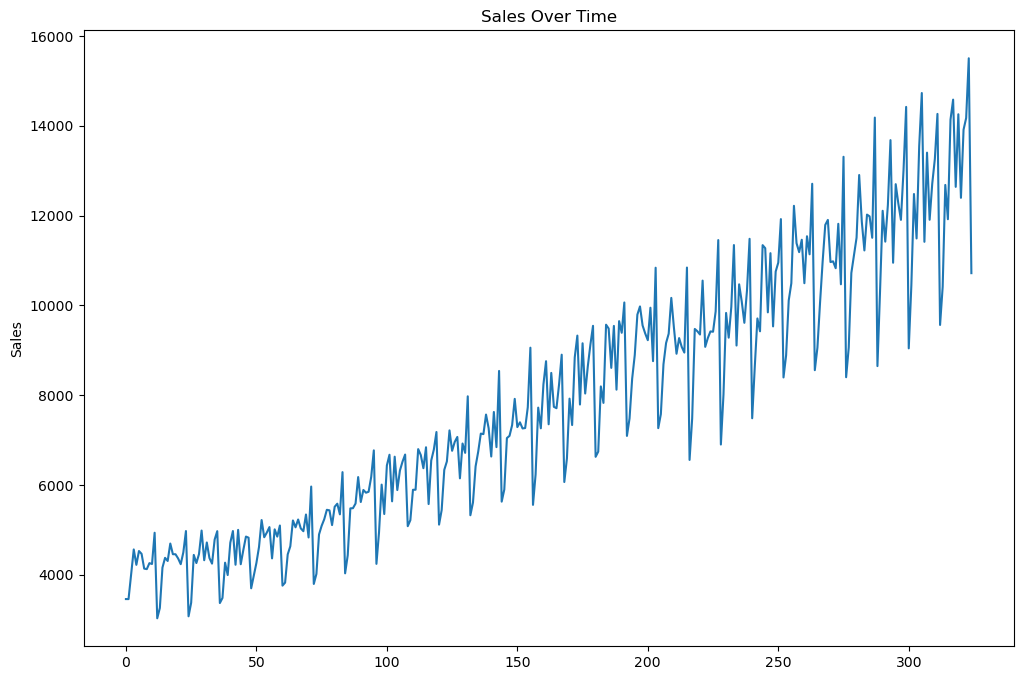

Reloading Tuner from my_dir/lstm_sales_tuning/tuner0.json
Best Hyperparameters:
{'units': 128, 'dropout': 0.30000000000000004, 'dense_units': 48}


KeyError: 'num_layers does not exist.'

In [14]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

# Step 1: Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Ensure the file path is correct

# Step 2: Explore and preprocess the data
print("Original columns:", df.columns)  # Display column names
df.columns = ['DATE', 'Sales']  # Rename columns if needed
print(df.head())  # Display the first few rows

# Convert the DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Plot the sales data
plt.figure(figsize=(12, 8))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Step 3: Create lagged features
df['Sale_LastMonth'] = df['Sales'].shift(1)
df['Sale_2Monthsback'] = df['Sales'].shift(2)
df['Sale_3Monthback'] = df['Sales'].shift(3)

# Drop rows with missing values due to shifting
df = df.dropna()

# Step 4: Prepare the data
x = df.iloc[:, 2:].values  # Use lagged features as input
y = df.iloc[:, 1:2].values  # Use current sales as target

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

# Reshape the data for LSTM input
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

# Step 5: Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 3)  # Number of LSTM layers
    for i in range(num_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=16),
            activation='relu',
            return_sequences=(i < num_layers - 1),  # Return sequences for all but the last layer
            input_shape=(xtrain.shape[1], 1) if i == 0 else None
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layers
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# Step 6: Hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_sales_tuning',
    
)

# Run the tuner
tuner.search(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), batch_size=5)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Debugging: Print all available hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)

# Use `best_hps` values to dynamically retrieve hyperparameter keys
num_layers = best_hps.get('num_layers')  # Ensure it's present
units_per_layer = [best_hps.get(f'units_{i}') for i in range(num_layers)]
dropout_rates = [best_hps.get(f'dropout_{i}') for i in range(num_layers)]
dense_units = best_hps.get('dense_units')
optimizer = best_hps.get('optimizer')

print(f"""
The optimal number of LSTM layers is {num_layers},
with the following units per layer: {units_per_layer}.
The dropout rates are {dropout_rates}.
The dense layer has {dense_units} units.
The optimizer is {optimizer}.
""")

# Step 7: Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(xtrain, ytrain, epochs=60, batch_size=5, validation_data=(xtest, ytest))

# Step 8: Evaluate the best model
loss, mae = best_model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Step 9: Predict and visualize results
predictions = best_model.predict(xtest)
predictions_rescaled = scaler_y.inverse_transform(predictions)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend()
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()


Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')
         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


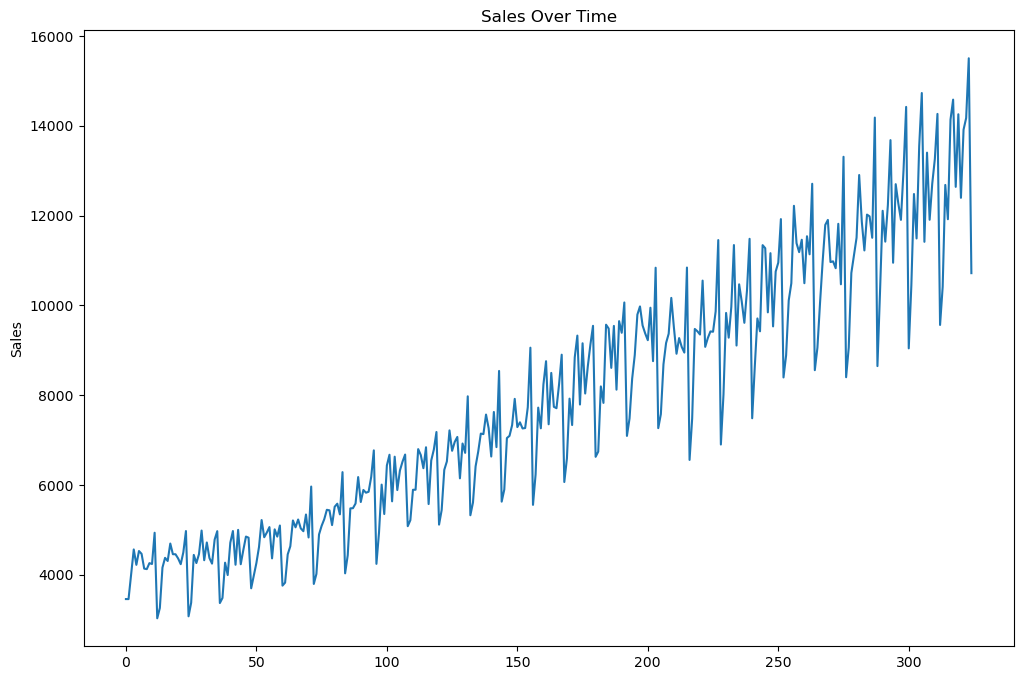

Reloading Tuner from my_dir/lstm_sales_tuning/tuner0.json
Error: 'num_layers' is not available in the best hyperparameters.
Epoch 1/60


/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1482 - mean_absolute_error: 0.3193 - val_loss: 0.0324 - val_mean_absolute_error: 0.1485
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 - mean_absolute_error: 0.1382 - val_loss: 0.0183 - val_mean_absolute_error: 0.1126
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.0992 - val_loss: 0.0070 - val_mean_absolute_error: 0.0626
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - mean_absolute_error: 0.0826 - val_loss: 0.0070 - val_mean_absolute_error: 0.0621
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - mean_absolute_error: 0.0812 - val_loss: 0.0076 - val_mean_absolute_error: 0.0651
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - mean_absolute_error: 0.0858 - val_loss: 0.0064 - val_mean_absolute_error: 0.0585
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0807 - val_loss: 0.0066 - val_mea

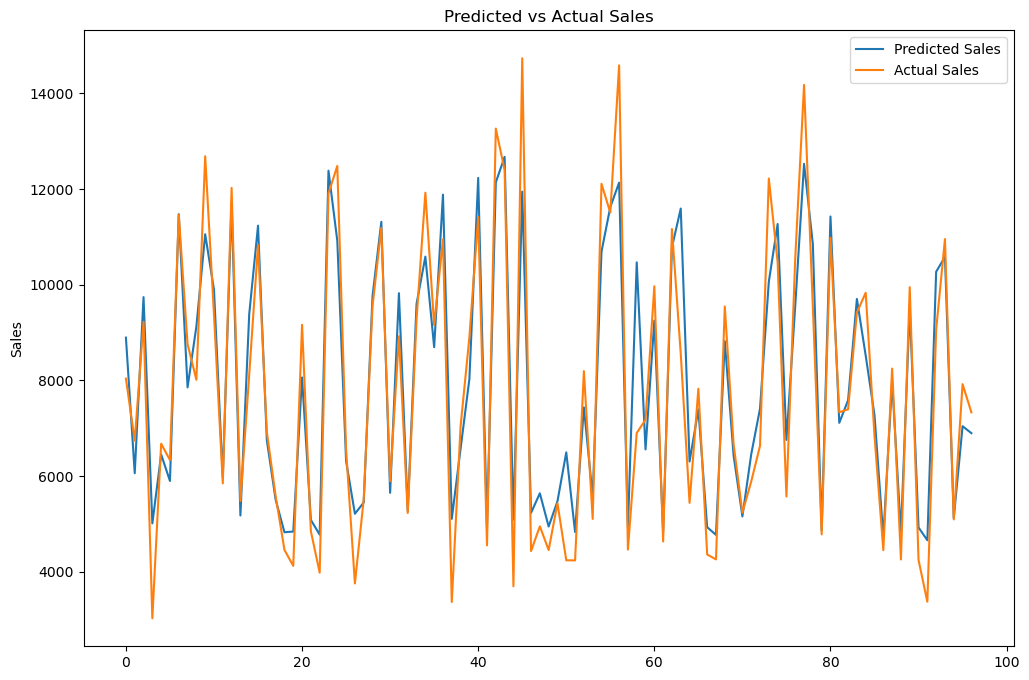

In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

# Step 1: Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Ensure the file path is correct

# Step 2: Explore and preprocess the data
print("Original columns:", df.columns)  # Display column names
df.columns = ['DATE', 'Sales']  # Rename columns if needed
print(df.head())  # Display the first few rows

# Convert the DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Plot the sales data
plt.figure(figsize=(12, 8))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Step 3: Create lagged features
df['Sale_LastMonth'] = df['Sales'].shift(1)
df['Sale_2Monthsback'] = df['Sales'].shift(2)
df['Sale_3Monthback'] = df['Sales'].shift(3)

# Drop rows with missing values due to shifting
df = df.dropna()

# Step 4: Prepare the data
x = df.iloc[:, 2:].values  # Use lagged features as input
y = df.iloc[:, 1:2].values  # Use current sales as target

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

# Reshape the data for LSTM input
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

# Step 5: Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 3)  # Number of LSTM layers
    for i in range(num_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=16),
            activation='relu',
            return_sequences=(i < num_layers - 1),  # Return sequences for all but the last layer
            input_shape=(xtrain.shape[1], 1) if i == 0 else None
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layers
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# Step 6: Hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_sales_tuning'
)

# Run the tuner
tuner.search(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), batch_size=5)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Safely retrieve and print hyperparameters
if 'num_layers' in best_hps.values:
    num_layers = best_hps.get('num_layers')
    units_per_layer = [best_hps.get(f'units_{i}') for i in range(num_layers)]
    dropout_rates = [best_hps.get(f'dropout_{i}') for i in range(num_layers)]
    dense_units = best_hps.get('dense_units')
    optimizer = best_hps.get('optimizer')

    print(f"""
    The optimal number of LSTM layers is {num_layers},
    with the following units per layer: {units_per_layer}.
    The dropout rates are {dropout_rates}.
    The dense layer has {dense_units} units.
    The optimizer is {optimizer}.
    """)
else:
    print("Error: 'num_layers' is not available in the best hyperparameters.")

# Step 7: Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(xtrain, ytrain, epochs=60, batch_size=5, validation_data=(xtest, ytest))

# Step 8: Evaluate the best model
loss, mae = best_model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Step 9: Predict and visualize results
predictions = best_model.predict(xtest)
predictions_rescaled = scaler_y.inverse_transform(predictions)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend()
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()


Original columns: Index(['DATE', 'S4248SM144NCEN'], dtype='object')
         DATE  Sales
0  1992-01-01   3459
1  1992-02-01   3458
2  1992-03-01   4002
3  1992-04-01   4564
4  1992-05-01   4221


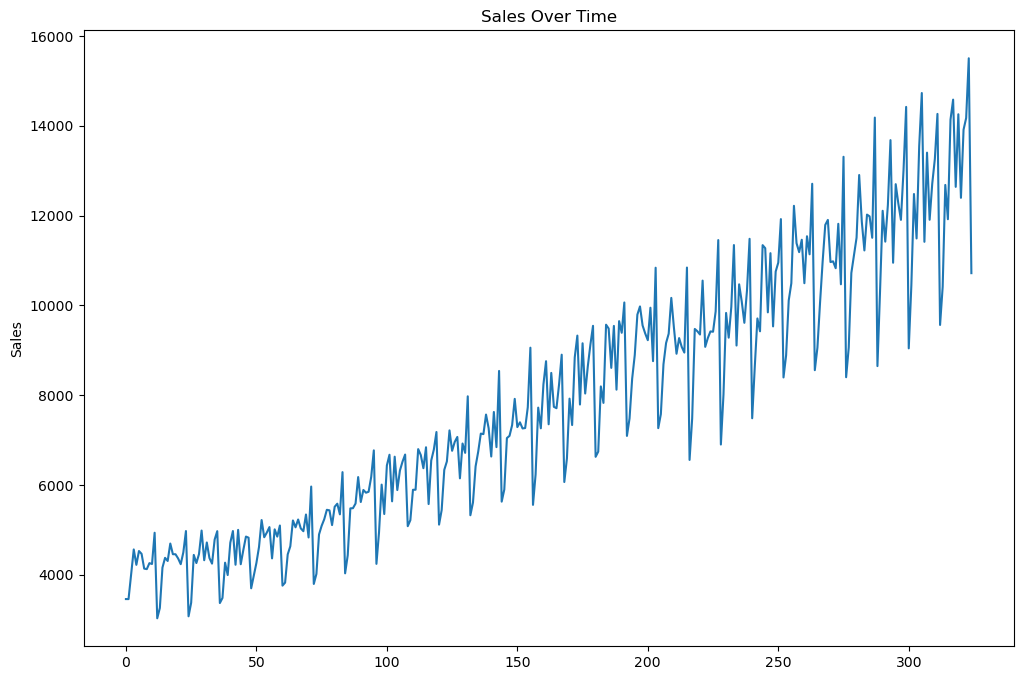

Reloading Tuner from my_dir/lstm_sales_tuning/tuner0.json
Error: 'num_layers' is not available in the best hyperparameters.
Epoch 1/60


/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1374 - mean_absolute_error: 0.2997 - val_loss: 0.0287 - val_mean_absolute_error: 0.1443
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285 - mean_absolute_error: 0.1451 - val_loss: 0.0198 - val_mean_absolute_error: 0.1177
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - mean_absolute_error: 0.1105 - val_loss: 0.0117 - val_mean_absolute_error: 0.0872
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0910 - val_loss: 0.0082 - val_mean_absolute_error: 0.0718
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0871 - val_loss: 0.0096 - val_mean_absolute_error: 0.0759
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0857 - val_loss: 0.0071 - val_mean_absolute_error: 0.0647
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mean_absolute_error: 0.0811 - val_loss: 0.0073 - val_mea

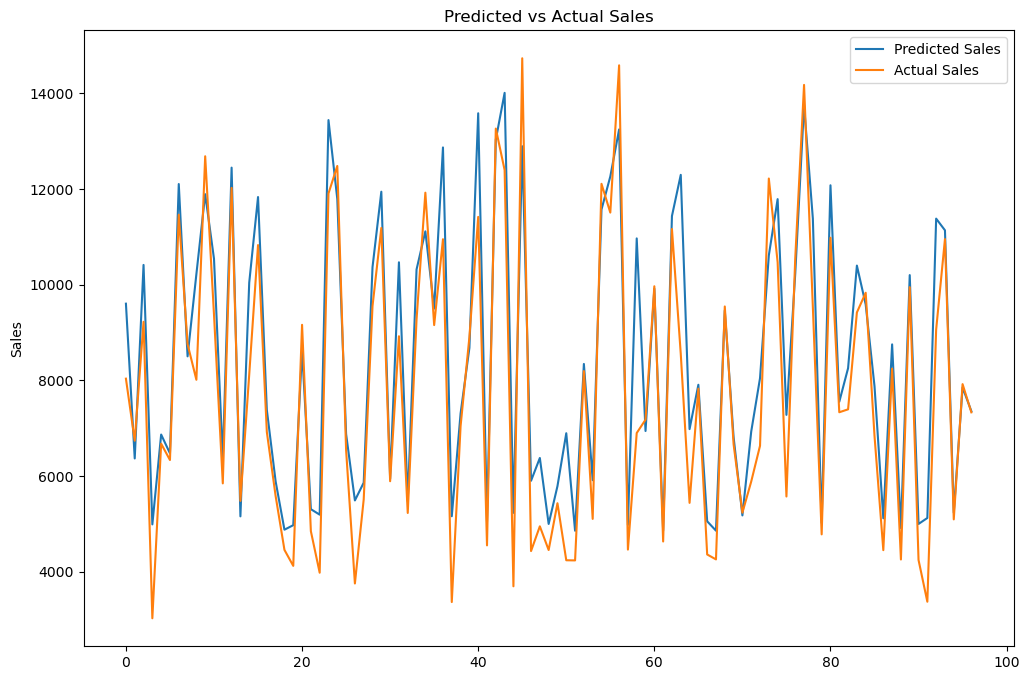

In [18]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

# Step 1: Load the data
df = pd.read_csv('Alcohol_Sales.csv')  # Ensure the file path is correct

# Step 2: Explore and preprocess the data
print("Original columns:", df.columns)  # Display column names
df.columns = ['DATE', 'Sales']  # Rename columns if needed
print(df.head())  # Display the first few rows

# Convert the DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Plot the sales data
plt.figure(figsize=(12, 8))
plt.plot(df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Step 3: Create lagged features
df['Sale_LastMonth'] = df['Sales'].shift(1)
df['Sale_2Monthsback'] = df['Sales'].shift(2)
df['Sale_3Monthback'] = df['Sales'].shift(3)

# Drop rows with missing values due to shifting
df = df.dropna()

# Step 4: Prepare the data
x = df.iloc[:, 2:].values  # Use lagged features as input
y = df.iloc[:, 1:2].values  # Use current sales as target

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xtrain = scaler_x.fit_transform(xtrain)
xtest = scaler_x.transform(xtest)
ytrain = scaler_y.fit_transform(ytrain)
ytest = scaler_y.transform(ytest)

# Reshape the data for LSTM input
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

# Step 5: Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 3)  # Number of LSTM layers
    for i in range(num_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=16),
            activation='relu',
            return_sequences=(i < num_layers - 1),  # Return sequences for all but the last layer
            input_shape=(xtrain.shape[1], 1) if i == 0 else None
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layers
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# Step 6: Hyperparameter optimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_sales_tuning'
)

# Run the tuner
tuner.search(xtrain, ytrain, epochs=50, validation_data=(xtest, ytest), batch_size=5)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Safely retrieve and print hyperparameters
if 'num_layers' in best_hps.values:
    num_layers = best_hps.get('num_layers')
    units_per_layer = [best_hps.get(f'units_{i}') for i in range(num_layers)]
    dropout_rates = [best_hps.get(f'dropout_{i}') for i in range(num_layers)]
    dense_units = best_hps.get('dense_units')
    optimizer = best_hps.get('optimizer')

    print(f"""
    The optimal number of LSTM layers is {num_layers},
    with the following units per layer: {units_per_layer}.
    The dropout rates are {dropout_rates}.
    The dense layer has {dense_units} units.
    The optimizer is {optimizer}.
    """)
else:
    print("Error: 'num_layers' is not available in the best hyperparameters.")

# Step 7: Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(xtrain, ytrain, epochs=60, batch_size=5, validation_data=(xtest, ytest))

# Step 8: Save loss history to CSV
history_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
history_df.to_csv('training_history.csv', index=False)
print("Training history saved to 'training_history.csv'.")

# Step 9: Evaluate the best model
loss, mae = best_model.evaluate(xtest, ytest)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Step 10: Predict and visualize results
predictions = best_model.predict(xtest)
predictions_rescaled = scaler_y.inverse_transform(predictions)
ytest_rescaled = scaler_y.inverse_transform(ytest)

plt.figure(figsize=(12, 8))
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.plot(ytest_rescaled, label='Actual Sales')
plt.legend()
plt.title('Predicted vs Actual Sales')
plt.ylabel('Sales')
plt.show()


         Date Close/Last    Volume     Open     High        Low
0  01/03/2025    $243.36  40244110  $243.36  $244.18    $241.89
1  01/02/2025    $243.85  55740730  $248.93  $249.10  $241.8201
2  12/31/2024    $250.42  39480720  $252.44  $253.28    $249.43
3  12/30/2024    $252.20  35557540  $252.23  $253.50    $250.75
4  12/27/2024    $255.59  42355320  $257.83  $258.70    $253.06
Training with optimizer=adam, dropout_rate=0.2, units_per_layer=[10], batch_size=16, epochs=20, num_layers=5, activation=relu


/home/suchi/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Loss: 0.15911933779716492
Training with optimizer=adam, dropout_rate=0.2, units_per_layer=[10], batch_size=16, epochs=20, num_layers=5, activation=sigmoid
Loss: 0.7810068130493164
Training with optimizer=adam, dropout_rate=0.2, units_per_layer=[10], batch_size=16, epochs=20, num_layers=7, activation=relu
Loss: 0.2367076724767685
Training with optimizer=adam, dropout_rate=0.2, units_per_layer=[10], batch_size=16, epochs=20, num_layers=7, activation=sigmoid
Loss: 0.3007947504520416
Training with optimizer=adam, dropout_rate=0.2, units_per_layer=[10], batch_size=32, epochs=20, num_layers=5, activation=relu
Loss: 0.16743645071983337
Training with optimizer=adam, dropout_rate=0.2, units_per_layer=[10], batch_size=32, epochs=20, num_layers=5, activation=sigmoid
Loss: 0.07943160831928253
Training with optimizer=adam, dropout_rate=0.2, units_per_layer=[10], batch_size=32, epochs=20, num_layers=7, activation=relu
Loss: 0.19961857795715332
Training with optimizer=adam, dropout_rate=0.2, units_pe

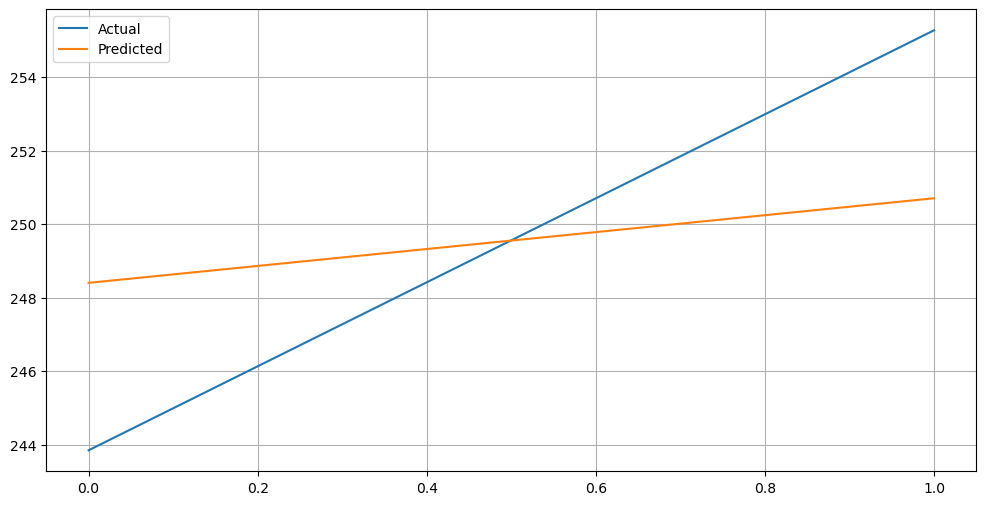

In [30]:
# -*- coding: utf-8 -*-
"""LSTM_HP_tuning_dataset.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1xTIb6RELI1wwliLZDs5upvgeOJyTduvQ
"""

#pip install --upgrade scikit-learn scikeras[tensorflow]
#pip install scikeras[tensorflow]

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


import csv


#from google.colab import files


# Upload the dataset manually
#uploaded = files.upload()

# Assuming the dataset is named 'stock_prices.csv'
df = pd.read_csv("HistoricalData.csv")
print(df.head())

data=df

# Assume 'Close' column contains the stock prices
target = df['Close/Last'].values

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
for col in ['Close/Last', 'Open', 'High', 'Low']:
    # Ensure the column is a string before applying .str.replace
    data[col] = data[col].astype(str).str.replace('$', '', regex=False).astype(float)

# Sort by date
data.sort_values(by='Date', inplace=True)

# Feature selection
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close/Last'

# Normalize the data
scaler = MinMaxScaler()
# Ensure all columns are numeric and handle missing values
data[features + [target]] = data[features + [target]].apply(pd.to_numeric, errors='coerce')
data = data.dropna()  # Drop rows with NaN values
scaled_data = scaler.fit_transform(data[features + [target]])

# Prepare the sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

sequence_length = 10  # Hyperparameter
data_sequences, target_sequences = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_sequences, target_sequences, test_size=0.2, random_state=42)

# Define the LSTM model
def build_lstm(optimizer='adam', dropout_rate=0.2, units_per_layer=[15],num_layers='5', activation='relu'):
    model = Sequential()
    
    # Add LSTM layers based on units_per_layer
    for i, units in enumerate(units_per_layer):
        return_seq = i < (len(units_per_layer) - 1)  # Only the last layer does not return sequences
        if i == 0:
            model.add(LSTM(units=units, return_sequences=return_seq, activation=activation,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units=units, return_sequences=return_seq, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Add output layer
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Focus on two optimizers
    'dropout_rate': [0.2, 0.3],  # Limit to two dropout rates
    'units_per_layer': [[10], [50]],  # Use fewer configurations
    'batch_size': [16, 32],  # Use moderate batch sizes
    'epochs': [20],  # Start with fewer epochs
    'num_layers': [5,7],  # Limit to 5-7 layers
    'activation': ['relu', 'sigmoid']  # Stick to commonly effective activations
}

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_loss = float('inf')
best_params = None
best_model = None

# Define the CSV file name
output_file = 'B190305001_FarhanaAkterSuci.csv'

# Open the file and create a CSV writer
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['optimizer', 'dropout_rate', 'units_per_layer', 'batch_size', 'epochs','num_layers','activation', 'loss'])
    
    # Iterate over all hyperparameter combinations
    for optimizer in param_grid['optimizer']:
        for dropout_rate in param_grid['dropout_rate']:
            for units_per_layer in param_grid['units_per_layer']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                       for num_layers in param_grid['num_layers']:
                            for activation in param_grid['activation']:
                                print(f"Training with optimizer={optimizer}, dropout_rate={dropout_rate}, units_per_layer={units_per_layer}, "
                                      f"batch_size={batch_size}, epochs={epochs}, num_layers={num_layers}, activation={activation}")
                                
                                # Build and train the model
                                model = build_lstm(optimizer=optimizer, dropout_rate=dropout_rate, units_per_layer=units_per_layer, 
                                                   num_layers=num_layers, activation=activation)
                                model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                                
                                # Evaluate the model
                                loss = model.evaluate(X_test, y_test, verbose=0)
                                print(f"Loss: {loss}")
                                
                                # Write the hyperparameters and loss to the CSV file
                                writer.writerow([optimizer, dropout_rate, units_per_layer, batch_size, epochs, num_layers, activation, loss])
                                
                                # Update best parameters if loss improves
                                if loss < best_loss:
                                    best_loss = loss
                                    best_params = {
                                        'optimizer': optimizer,
                                        'dropout_rate': dropout_rate,
                                        'units_per_layer': units_per_layer,
                                        'batch_size': batch_size,
                                        'epochs': epochs,
                                        'num_layers': num_layers,
                                        'activation': activation
                                    }
                                    best_model = model

print("Best parameters found: ", best_params)
                        
 

# Predict
predicted = best_model.predict(X_test)

# Inverse transform to get actual values
# Create a dummy array to match the scaler's input shape for inverse transformation
dummy_features = np.zeros((predicted.shape[0], len(features)))  # Matching the feature columns
dummy_data = np.hstack((dummy_features, predicted.reshape(-1, 1)))

# Inverse transform to get actual predicted values
predicted_actual = scaler.inverse_transform(dummy_data)[:, -1]

# Similarly, process the test target values
dummy_test_features = np.zeros((y_test.shape[0], len(features)))
dummy_test_data = np.hstack((dummy_test_features, y_test.reshape(-1, 1)))
y_test_actual = scaler.inverse_transform(dummy_test_data)[:, -1]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_actual, label='Predicted')
plt.legend()
plt.grid()
#plt.title('LSTM Predictions vs Actual Data')
#plt.show()
#plt.savefig('LSTM Predictions vs Actual Data.png')
#print("The training vs testing loss plot has been saved as 'LSTM Predictions vs Actual Data.png'.")